In [9]:
import sys
sys.setrecursionlimit(10000)

import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("checkpoints", exist_ok=True)


In [10]:
def to_tensor(X, y):
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor


class TabularNet(nn.Module):
    def __init__(self, input_size, output_size=2, hidden_sizes=(256, 128, 64)):
        super().__init__()
        h1, h2, h3 = hidden_sizes
        self.model = nn.Sequential(
            nn.Linear(input_size, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, h3), nn.ReLU(),
            nn.Linear(h3, output_size)
        )

    def forward(self, x):
        return self.model(x)


In [3]:
def compute_spectral_norm(matrix):
    return torch.linalg.matrix_norm(matrix, ord=2)


def compute_l21_norm(matrix):
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))


def compute_spectral_complexity(model: nn.Module):
    product_terms = []
    summation_terms = []

    for module in model.modules():
        if isinstance(module, nn.Linear):
            A_i = module.weight.data
            s_i = compute_spectral_norm(A_i)

            M_i = torch.eye(A_i.size(0), A_i.size(1), device=A_i.device)
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            sum_term = (deviation_norm / (s_i + 1e-12)) ** (2 / 3)

            product_terms.append(s_i)
            summation_terms.append(sum_term)

    total_product = torch.prod(torch.stack(product_terms))
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum ** (3 / 2)
    R_A = total_product * final_sum_term
    return R_A, total_product, final_sum_term


In [4]:
def compute_dataset_l2_norm(loader):
    total_sq = 0.0
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                inputs = batch[0]
            else:
                inputs = batch
            total_sq += torch.sum(inputs.float() ** 2).item()
    return total_sq ** 0.5


In [11]:
def evaluate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return correct / max(total, 1)


def train_tabular_model(
    train_loader,
    val_loader,
    input_dim,
    num_classes,
    checkpoint_dir,
    checkpoint_epochs,
    total_epochs=120,
    lr=1e-3,
    dataset_label="TABULAR",
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    model = TabularNet(input_dim, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_history = []
    val_history = []

    for epoch in range(1, total_epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{total_epochs}", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        train_acc = evaluate_accuracy(model, train_loader)
        val_acc = evaluate_accuracy(model, val_loader)
        train_history.append(train_acc)
        val_history.append(val_acc)

        if epoch in checkpoint_epochs:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"epoch_{epoch}.pth"))

        print(f"[{dataset_label}] Epoch {epoch:03d} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")

    return train_history, val_history


def collect_gamma_distribution(model, loader):
    diffs = []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Eval", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            top2 = torch.topk(outputs, k=min(2, outputs.shape[1]), dim=1).values
            if outputs.shape[1] == 1:
                gamma_values = top2[:, 0]
            else:
                gamma_values = top2[:, 0] - top2[:, 1]
            diffs.extend(gamma_values.cpu().numpy())
    return np.array(diffs)


def compute_gamma_from_checkpoint(model_path, input_dim, num_classes, eval_loader):
    print(f"Loading checkpoint: {model_path}")
    model = TabularNet(input_dim, num_classes).to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    print()
    print("Computing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Product Component: {product_component.item():.4e}")
    print(f"Summation Component: {sum_component.item():.4e}")
    print(f"Total Spectral Complexity: {spectral_complexity.item():.4e}")
    print(f"Total Computation Time: {end_time - start_time:.4f}s")

    dataset_l2_norm = compute_dataset_l2_norm(eval_loader)
    diffs = collect_gamma_distribution(model, eval_loader)
    scaling = spectral_complexity.item() * dataset_l2_norm
    return diffs / scaling


def plot_accuracy_curves(train_hist, val_hist, dataset_label):
    epochs = range(1, len(train_hist) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_hist, label="Train Accuracy")
    plt.plot(epochs, val_hist, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{dataset_label} Accuracy Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{dataset_label.lower()}_accuracy_curve.png")
    plt.show()


In [12]:
CHECKPOINT_DIR = "ckpt_tabular_german"
CHECKPOINT_EPOCHS = [5, 40, 120]
TOTAL_EPOCHS = 500
BATCH_SIZE = 512

GERMAN_COLUMNS = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount", "Savings",
    "EmploymentSince", "InstallmentRate", "SexAndStatus", "OtherDebtors",
    "ResidenceSince", "Property", "Age", "OtherInstallmentPlans", "Housing",
    "ExistingCredits", "Job", "NumPeopleLiable", "Telephone", "ForeignWorker", "Target"
]

def prepare_german_split(test_size=0.2, random_state=42):
    df = pd.read_csv(
        "german.data",
        delim_whitespace=True,
        header=None,
        names=GERMAN_COLUMNS,
    )
    df["Target"] -= 1
    X = df.drop(columns="Target")
    y = df["Target"].astype(int)
    cat_cols = X.select_dtypes(include=["object"]).columns
    num_cols = X.select_dtypes(exclude=["object"]).columns
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])
    X_proc = preprocessor.fit_transform(X)
    Xt, Xv, yt, yv = train_test_split(
        X_proc,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )
    Xt, yt = to_tensor(Xt, yt)
    Xv, yv = to_tensor(Xv, yv)
    train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(TensorDataset(Xv, yv), batch_size=BATCH_SIZE, shuffle=False)
    input_dim = Xt.shape[1]
    num_classes = 2
    return train_loader, eval_loader, input_dim, num_classes

os.makedirs(CHECKPOINT_DIR, exist_ok=True)


In [12]:
def compute_gamma_distribution(model_path):
    _, eval_loader, input_dim, num_classes = prepare_german_split()
    return compute_gamma_from_checkpoint(model_path, input_dim, num_classes, eval_loader)

underfit = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[0]}.pth"))
correct = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[1]}.pth"))
overfit = compute_gamma_distribution(os.path.join(CHECKPOINT_DIR, f"epoch_{CHECKPOINT_EPOCHS[2]}.pth"))


/var/folders/96/s7zm7_qd5tl766bx8kyp31gm0000gn/T/ipykernel_72510/2735073352.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loading checkpoint: ckpt_tabular_german/epoch_5.pth

Computing spectral complexity...
Product Component: 1.2858e+00
Summation Component: 5.3755e+02
Total Spectral Complexity: 6.9119e+02
Total Computation Time: 0.0395s


/var/folders/96/s7zm7_qd5tl766bx8kyp31gm0000gn/T/ipykernel_72510/2735073352.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loading checkpoint: ckpt_tabular_german/epoch_40.pth

Computing spectral complexity...
Product Component: 3.1865e+01
Summation Component: 2.5700e+02
Total Spectral Complexity: 8.1896e+03
Total Computation Time: 0.0021s


/var/folders/96/s7zm7_qd5tl766bx8kyp31gm0000gn/T/ipykernel_72510/2735073352.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Loading checkpoint: ckpt_tabular_german/epoch_120.pth

Computing spectral complexity...
Product Component: 1.0028e+02
Summation Component: 2.2138e+02
Total Spectral Complexity: 2.2199e+04
Total Computation Time: 0.0021s


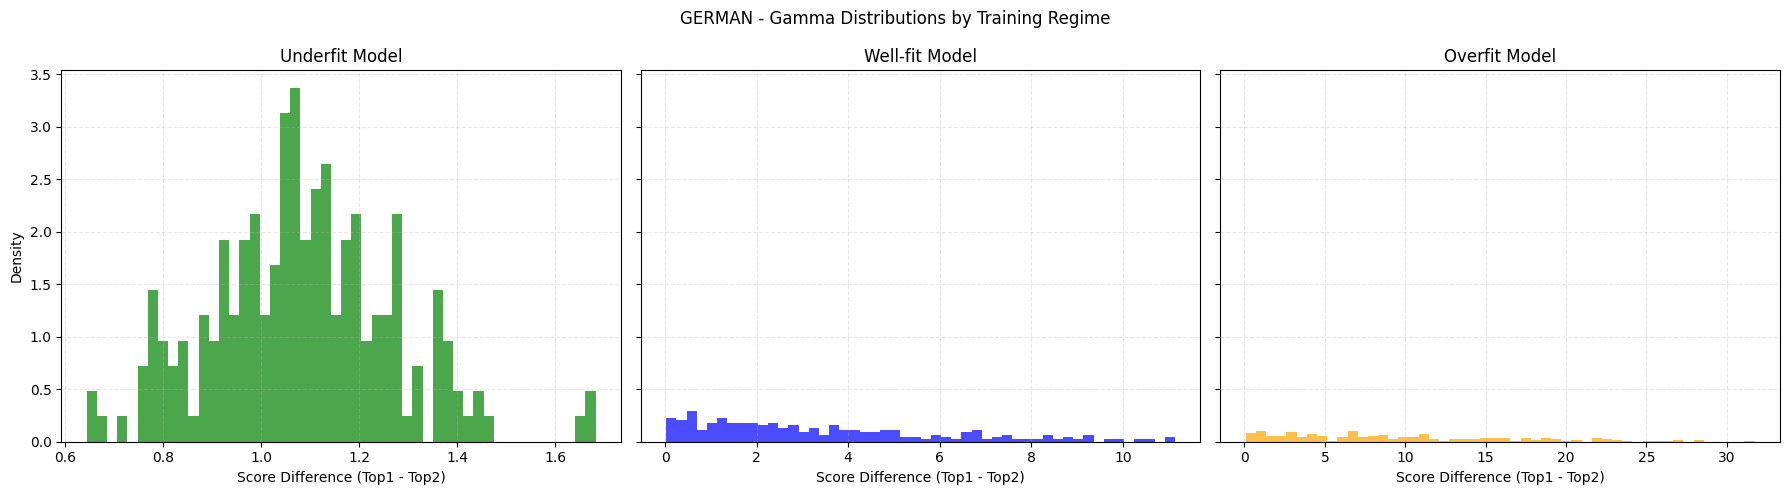

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
regimes = [
    (underfit, "Underfit", "green"),
    (correct, "Well-fit", "blue"),
    (overfit, "Overfit", "orange"),
]
for ax, (values, regime_label, color) in zip(axes, regimes):
    ax.hist(values, bins=50, alpha=0.7, color=color, density=True)
    ax.set_title(f"{regime_label} Model")
    ax.set_xlabel("Score Difference (Top1 - Top2)")
    ax.grid(True, linestyle='--', alpha=0.3)
axes[0].set_ylabel("Density")
fig.suptitle("GERMAN - Gamma Distributions by Training Regime")
fig.tight_layout()
plt.show()


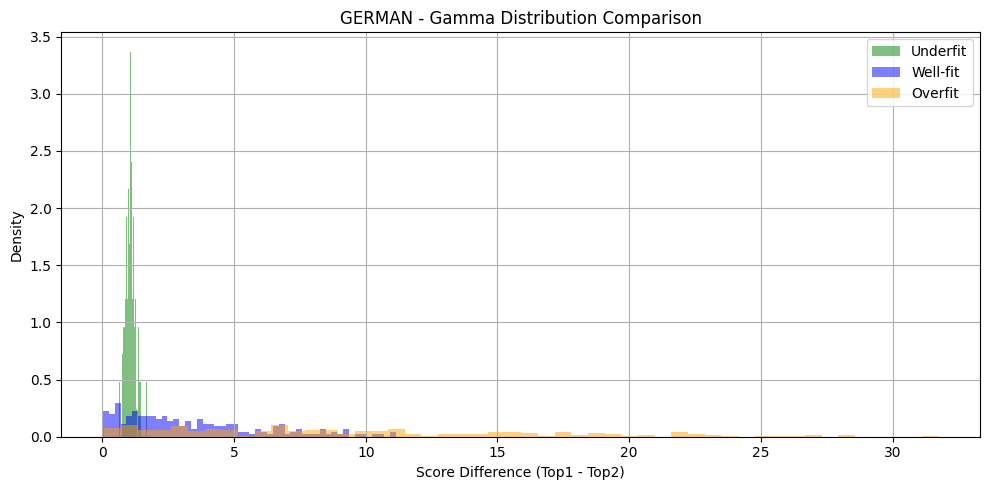

In [14]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.5, label="Underfit", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.5, label="Well-fit", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.5, label="Overfit", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title("GERMAN - Gamma Distribution Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_spectral_norm_tabular_german.png")
plt.show()


/tmp/ipykernel_2298081/2197586850.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


[GERMAN] Epoch 001 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 002 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 003 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 004 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 005 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 006 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 007 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 008 | Train Acc: 70.00% | Val Acc: 70.00%


[GERMAN] Epoch 009 | Train Acc: 70.75% | Val Acc: 71.50%


[GERMAN] Epoch 010 | Train Acc: 71.38% | Val Acc: 73.00%


[GERMAN] Epoch 011 | Train Acc: 72.62% | Val Acc: 72.50%


[GERMAN] Epoch 012 | Train Acc: 72.62% | Val Acc: 75.00%


[GERMAN] Epoch 013 | Train Acc: 75.62% | Val Acc: 77.00%


[GERMAN] Epoch 014 | Train Acc: 77.88% | Val Acc: 78.00%


[GERMAN] Epoch 015 | Train Acc: 78.75% | Val Acc: 77.50%


[GERMAN] Epoch 016 | Train Acc: 78.38% | Val Acc: 76.00%


[GERMAN] Epoch 017 | Train Acc: 78.50% | Val Acc: 76.50%


[GERMAN] Epoch 018 | Train Acc: 78.62% | Val Acc: 76.50%


[GERMAN] Epoch 019 | Train Acc: 79.00% | Val Acc: 78.50%


[GERMAN] Epoch 020 | Train Acc: 79.75% | Val Acc: 78.00%


[GERMAN] Epoch 021 | Train Acc: 80.00% | Val Acc: 77.50%


[GERMAN] Epoch 022 | Train Acc: 81.12% | Val Acc: 76.50%


[GERMAN] Epoch 023 | Train Acc: 81.25% | Val Acc: 78.50%


[GERMAN] Epoch 024 | Train Acc: 82.50% | Val Acc: 77.50%


[GERMAN] Epoch 025 | Train Acc: 83.50% | Val Acc: 77.50%


[GERMAN] Epoch 026 | Train Acc: 84.00% | Val Acc: 77.50%


[GERMAN] Epoch 027 | Train Acc: 85.12% | Val Acc: 78.50%


[GERMAN] Epoch 028 | Train Acc: 85.88% | Val Acc: 77.50%


[GERMAN] Epoch 029 | Train Acc: 86.62% | Val Acc: 77.50%


[GERMAN] Epoch 030 | Train Acc: 87.25% | Val Acc: 77.50%


[GERMAN] Epoch 031 | Train Acc: 88.38% | Val Acc: 77.50%

[GERMAN] Epoch 032 | Train Acc: 89.25% | Val Acc: 77.50%


[GERMAN] Epoch 033 | Train Acc: 89.62% | Val Acc: 77.00%


[GERMAN] Epoch 034 | Train Acc: 90.50% | Val Acc: 76.50%


[GERMAN] Epoch 035 | Train Acc: 92.50% | Val Acc: 77.00%


[GERMAN] Epoch 036 | Train Acc: 92.88% | Val Acc: 77.50%


[GERMAN] Epoch 037 | Train Acc: 93.50% | Val Acc: 77.50%


[GERMAN] Epoch 038 | Train Acc: 93.25% | Val Acc: 78.00%


[GERMAN] Epoch 039 | Train Acc: 94.50% | Val Acc: 77.50%


[GERMAN] Epoch 040 | Train Acc: 95.62% | Val Acc: 78.00%


[GERMAN] Epoch 041 | Train Acc: 95.25% | Val Acc: 77.00%


[GERMAN] Epoch 042 | Train Acc: 97.50% | Val Acc: 77.50%


[GERMAN] Epoch 043 | Train Acc: 97.12% | Val Acc: 76.50%


[GERMAN] Epoch 044 | Train Acc: 98.25% | Val Acc: 76.50%


[GERMAN] Epoch 045 | Train Acc: 98.50% | Val Acc: 76.00%


[GERMAN] Epoch 046 | Train Acc: 99.00% | Val Acc: 76.50%


[GERMAN] Epoch 047 | Train Acc: 99.00% | Val Acc: 76.00%


[GERMAN] Epoch 048 | Train Acc: 99.38% | Val Acc: 77.00%


[GERMAN] Epoch 049 | Train Acc: 99.62% | Val Acc: 76.00%


[GERMAN] Epoch 050 | Train Acc: 99.50% | Val Acc: 78.50%


[GERMAN] Epoch 051 | Train Acc: 99.62% | Val Acc: 77.50%


[GERMAN] Epoch 052 | Train Acc: 99.88% | Val Acc: 77.50%


[GERMAN] Epoch 053 | Train Acc: 99.88% | Val Acc: 77.50%


[GERMAN] Epoch 054 | Train Acc: 99.88% | Val Acc: 77.50%


[GERMAN] Epoch 055 | Train Acc: 99.88% | Val Acc: 77.50%


[GERMAN] Epoch 056 | Train Acc: 100.00% | Val Acc: 77.00%


[GERMAN] Epoch 057 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 058 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 059 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 060 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 061 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 062 | Train Acc: 100.00% | Val Acc: 78.00%

[GERMAN] Epoch 063 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 064 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 065 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 066 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 067 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 068 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 069 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 070 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 071 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 072 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 073 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 074 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 075 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 076 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 077 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 078 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 079 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 080 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 081 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 082 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 083 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 084 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 085 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 086 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 087 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 088 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 089 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 090 | Train Acc: 100.00% | Val Acc: 77.50%


[GERMAN] Epoch 091 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 092 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 093 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 094 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 095 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 096 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 097 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 098 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 099 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 100 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 101 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 102 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 103 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 104 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 105 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 106 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 107 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 108 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 109 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 110 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 111 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 112 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 113 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 114 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 115 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 116 | Train Acc: 100.00% | Val Acc: 78.00%


[GERMAN] Epoch 117 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 118 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 119 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 120 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 121 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 122 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 123 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 124 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 125 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 126 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 127 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 128 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 129 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 130 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 131 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 132 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 133 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 134 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 135 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 136 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 137 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 138 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 139 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 140 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 141 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 142 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 143 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 144 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 145 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 146 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 147 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 148 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 149 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 150 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 151 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 152 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 153 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 154 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 155 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 156 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 157 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 158 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 159 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 160 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 161 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 162 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 163 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 164 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 165 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 166 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 167 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 168 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 169 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 170 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 171 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 172 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 173 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 174 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 175 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 176 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 177 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 178 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 179 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 180 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 181 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 182 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 183 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 184 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 185 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 186 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 187 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 188 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 189 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 190 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 191 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 192 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 193 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 194 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 195 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 196 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 197 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 198 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 199 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 200 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 201 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 202 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 203 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 204 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 205 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 206 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 207 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 208 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 209 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 210 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 211 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 212 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 213 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 214 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 215 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 216 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 217 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 218 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 219 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 220 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 221 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 222 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 223 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 224 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 225 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 226 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 227 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 228 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 229 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 230 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 231 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 232 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 233 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 234 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 235 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 236 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 237 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 238 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 239 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 240 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 241 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 242 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 243 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 244 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 245 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 246 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 247 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 248 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 249 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 250 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 251 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 252 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 253 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 254 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 255 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 256 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 257 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 258 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 259 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 260 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 261 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 262 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 263 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 264 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 265 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 266 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 267 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 268 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 269 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 270 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 271 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 272 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 273 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 274 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 275 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 276 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 277 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 278 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 279 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 280 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 281 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 282 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 283 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 284 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 285 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 286 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 287 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 288 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 289 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 290 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 291 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 292 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 293 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 294 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 295 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 296 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 297 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 298 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 299 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 300 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 301 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 302 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 303 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 304 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 305 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 306 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 307 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 308 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 309 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 310 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 311 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 312 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 313 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 314 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 315 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 316 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 317 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 318 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 319 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 320 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 321 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 322 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 323 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 324 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 325 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 326 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 327 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 328 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 329 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 330 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 331 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 332 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 333 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 334 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 335 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 336 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 337 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 338 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 339 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 340 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 341 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 342 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 343 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 344 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 345 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 346 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 347 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 348 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 349 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 350 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 351 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 352 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 353 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 354 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 355 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 356 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 357 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 358 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 359 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 360 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 361 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 362 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 363 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 364 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 365 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 366 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 367 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 368 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 369 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 370 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 371 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 372 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 373 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 374 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 375 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 376 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 377 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 378 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 379 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 380 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 381 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 382 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 383 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 384 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 385 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 386 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 387 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 388 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 389 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 390 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 391 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 392 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 393 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 394 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 395 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 396 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 397 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 398 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 399 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 400 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 401 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 402 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 403 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 404 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 405 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 406 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 407 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 408 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 409 | Train Acc: 100.00% | Val Acc: 78.50%

[GERMAN] Epoch 410 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 411 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 412 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 413 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 414 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 415 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 416 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 417 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 418 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 419 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 420 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 421 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 422 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 423 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 424 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 425 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 426 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 427 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 428 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 429 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 430 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 431 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 432 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 433 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 434 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 435 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 436 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 437 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 438 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 439 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 440 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 441 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 442 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 443 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 444 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 445 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 446 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 447 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 448 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 449 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 450 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 451 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 452 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 453 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 454 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 455 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 456 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 457 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 458 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 459 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 460 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 461 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 462 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 463 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 464 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 465 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 466 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 467 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 468 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 469 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 470 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 471 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 472 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 473 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 474 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 475 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 476 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 477 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 478 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 479 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 480 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 481 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 482 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 483 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 484 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 485 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 486 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 487 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 488 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 489 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 490 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 491 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 492 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 493 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 494 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 495 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 496 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 497 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 498 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 499 | Train Acc: 100.00% | Val Acc: 78.50%


[GERMAN] Epoch 500 | Train Acc: 100.00% | Val Acc: 78.50%


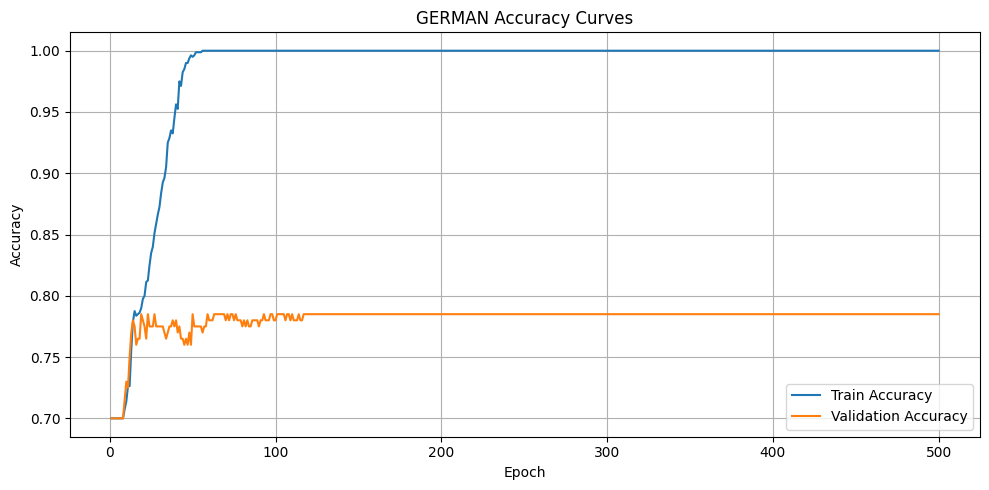

In [13]:
german_train_loader, german_eval_loader, german_input_dim, german_num_classes = prepare_german_split()

german_train_acc, german_eval_acc = train_tabular_model(
    german_train_loader,
    german_eval_loader,
    german_input_dim,
    german_num_classes,
    CHECKPOINT_DIR,
    CHECKPOINT_EPOCHS,
    total_epochs=TOTAL_EPOCHS,
    lr=1e-3,
    dataset_label="GERMAN",
)

plot_accuracy_curves(german_train_acc, german_eval_acc, "GERMAN")
